In [32]:
#%pip install bertopic pandas numpy 
#%pip install nbformat
#%pip install matplotlib
#%pip install seaborn
#%pip install statsmodels stargazer

In [84]:
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.cluster import KMeans
from umap import UMAP
from bertopic.vectorizers import ClassTfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
df = pd.read_stata('2021 Canadian Election Study v2.0.dta', convert_categoricals=False)

In [4]:
df.head()

cps21_StartDate       cps21_EndDate  Duration__in_seconds_  \
0 2021-09-19 06:14:46 2021-09-19 06:28:25                    818   
1 2021-09-15 15:23:33 2021-09-15 15:46:57                   1403   
2 2021-08-20 09:44:55 2021-08-20 09:57:51                    775   
3 2021-09-14 18:26:56 2021-09-14 18:40:41                    825   
4 2021-09-17 17:24:04 2021-09-17 17:51:44                   1660   

         RecordedDate   cps21_ResponseId DistributionChannel UserLanguage  \
0 2021-09-19 06:28:26  R_001Vw6R3CxCzbcR           anonymous        FR-CA   
1 2021-09-15 15:46:58  R_00AJoGE6B8Xifwl           anonymous           EN   
2 2021-08-20 09:57:52  R_00QYXuUFwGAZLgZ           anonymous           EN   
3 2021-09-14 18:40:42  R_00Wyqmxv6ek6e3L           anonymous           EN   
4 2021-09-17 17:51:45  R_00dscjzlw5eIgEx           anonymous        FR-CA   

   cps21_consent_t_First_Click  cps21_consent_t_Last_Click  \
0                        1.302                       9.791   
1                        2.488                       2.488   
2                        3.851                       8.468   
3                        1.527                       6.141   
4                        3.980                      20.523   

   cps21_consent_t_Page_Submit  ...  feduid  \
0                       10.761  ...   24042   
1                        3.287  ...   59025   
2                        8.501  ...   59021   
3                        6.942  ...   35008   
4                       23.784  ...   24015   

                             fedname  \
0                  Lévis--Lotbinière   
1  Richmond Centre / Richmond-Centre   
2                    North Vancouver   
3  Brampton Centre / Brampton-Centre   
4                           Bourassa   

                                             message  pccf_pcode_problem  \
0                                                                    0.0   
1                                                                    0.0   
2  0 ERROR: NO MATCH TO PCCF - CHECK PCODE/ADDRES...                 1.0   
3                                                                    0.0   
4                                                                    0.0   

   manual_PCCF  provcode  cps21_weight_general_all  \
0          0.0      24.0                  0.848994   
1          0.0      59.0                  0.868409   
2          0.0       NaN                  0.868409   
3          0.0      35.0                  0.804746   
4          0.0       NaN                  0.867096   

   cps21_weight_general_restricted  pes21_weight_general_all  \
0                         0.842803                  0.837168   
1                         0.887286                  1.056942   
2                         0.887286                  1.056942   
3                         0.811089                  0.967202   
4                         0.895935                       NaN   

   pes21_weight_general_restricted  
0                         0.822091  
1                         1.091878  
2                         1.091878  
3                         0.995020  
4                              NaN  

[5 rows x 1059 columns]

In [5]:
representation_model = KeyBERTInspired()

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42) #to create perfect replicability (set randome seed)

#reduce the importance of words related directly to Canada or canadians (and its derivatives) in the model
ctfidf_model = ClassTfidfTransformer(
    seed_words= ["Canada","Canadians","Canadiens","canada","canadian","canadiens"],
    seed_multiplier = 0.3
)


cluster_model = KMeans(n_clusters=300) #tuned by human inspection, starting at the hdbscan optimal 300 clusters, and trimming down for visibleoverlap
model = BERTopic(language = "multilingual", ctfidf_model=ctfidf_model,umap_model=umap_model, hdbscan_model= cluster_model) #multilingual model alows for french and english text to be semantically classified together
topics, probs = model.fit_transform(df["cps21_imp_iss"]) #important issues

In [6]:
model.get_topic_info().head(10)

Topic  Count                                               Name  \
0      0    619                                       0_economy___   
1      1    467  1_environnement_enrivonnement_emvironnement_cl...   
2      2    394                     2_covid_rexovery_corcetb_cobid   
3      3    360                            3_healthcare_medicare__   
4      4    273                           4_change_climate_climat_   
5      5    258                                 5_change_climate__   
6      6    242                                  6_economy_local__   
7      7    232                7_debt_dette_national_remboursement   
8      8    229               8_housing_logement_habitation_santes   
9      9    213                            9_change_climate_chang_   

                                      Representation  \
0                        [economy, , , , , , , , , ]   
1  [environnement, enrivonnement, emvironnement, ...   
2  [covid, rexovery, corcetb, cobid, things, main...   
3             [healthcare, medicare, , , , , , , , ]   
4            [change, climate, climat, , , , , , , ]   
5                  [change, climate, , , , , , , , ]   
6                   [economy, local, , , , , , , , ]   
7  [debt, dette, national, remboursement, country...   
8  [housing, logement, habitation, santes, housin...   
9             [change, climate, chang, , , , , , , ]   

                                Representative_Docs  
0                       [Economy, Economy, Economy]  
1     [Environnement, Environnement, Environnement]  
2                             [Covid, Covid, Covid]  
3              [Healthcare, Healthcare, Healthcare]  
4  [Climate change, Climate change, Climate change]  
5  [Climate change, Climate change, Climate change]  
6                       [economy, economy, economy]  
7                    [The debt, the debt, the debt]  
8                       [Housing, HOUSING, Housing]  
9  [climate change, climate change, climate change]

In [7]:
model.visualize_documents(df["cps21_imp_iss"])

In [8]:
#Manual Descisions Merge Categories
model.reduce_topics(df["cps21_imp_iss"], nr_topics = 200)
topics = model.topics_
probs = model.probabilities_

In [9]:
model.visualize_documents(df["cps21_imp_iss"])

In [10]:
df["cps21_imp_iss_topic_num"] = topics

def get_topic_name(topic_num):
    return model.get_topic_info(topic_num)["Name"]
    

df["cps21_imp_iss_topic_desc"] = df.apply(lambda row: get_topic_name(row["cps21_imp_iss_topic_num"]), axis=1)

/tmp/ipykernel_511922/1619572760.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_511922/1619572760.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [11]:
df[["cps21_imp_iss","cps21_imp_iss_topic_desc","cps21_imp_iss_party"]].head(10)

cps21_imp_iss  \
0                                           La dette   
1                                   Environmentalism   
2                       Access to education and jobs   
3                                           COVID-19   
4                                 Racisme systemique   
5  Transfert aux provinces - Sans ingérence du fé...   
6                                            Housing   
7                                           Economie   
8                                         L’économie   
9                               Keeping Canada whole   

                            cps21_imp_iss_topic_desc  cps21_imp_iss_party  
0                      146_dette_pendemie_la_relever                  2.0  
1  150_environmental_issues_concerns_environmenta...                  3.0  
2            34_education_éducation_secondary_school                  1.0  
3                 29_19_covid_covid19_lenvironnement                  1.0  
4           86_racism_minority_discrimination_racist                  7.0  
5              125_transferts_transfert_provinces_en                  4.0  
6                 11_housing_logement_santes_housinf                  7.0  
7                    0_economy_economie_économie_the                  2.0  
8                    0_economy_economie_économie_the                  2.0  
9                        10_canadians_western_all_in                  1.0

In [12]:
#TODO: Visualize for each party, what is the perceived categories for each perspective.
bins = [0,1,2,3,4,5,6,7]
names = ["Liberal", "Conservative", "NDP", "Bloc", "Green", "Other", "DK/NA"]
#classify as categorical.
df["cps21_imp_iss_party_names"] = pd.cut(df["cps21_imp_iss_party"], bins, labels=names)
#for each party, visualize the topics.
grouped = df.groupby(["cps21_imp_iss_party_names","cps21_imp_iss_topic_desc"]).size().reset_index(name='counts')

top_categories = {}
for category, group in grouped.groupby("cps21_imp_iss_party_names"):
    top_categories[category] = group.nlargest(5, "counts")

fix, axes = plt.subplots(nrows = len(top_categories), ncols = 1, figsize=(12, 30))
for i, (category, top) in enumerate(top_categories.items()):
    ax = axes[i]
    ax.bar(top["cps21_imp_iss_topic_desc"], top["counts"])
    ax.set_title(category)
    ax.set_ylabel('Counts')
    ax.set_xlabel('Topic')
    ax.set_xticklabels(ax.get_xticklabels(),rotation =20, ha = "right")

plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.show()



/tmp/ipykernel_511922/2913625824.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [51]:
pd.set_option('display.max_rows', None)
model.get_topic_info().head(200)

Topic  Count                                               Name  \
0        0   1429                    0_economy_economie_économie_the   
1        1   1207           1_change_climate_changements_climatiques   
2        2   1133                  2_healthcare_care_health_medicare   
3        3    660  3_environment_environnement_environement_envir...   
4        4    540                 4_covid_coilation_corcetb_rexovery   
5        5    467  5_environnement_enrivonnement_emvironnement_cl...   
6        6    395            6_affordable_housing_affordability_home   
7        7    366                           7_santé_la_health_santée   
8        8    345                       8_taxes_tax_taxation_capital   
9        9    327                           9_trudeau_justin_rid_out   
10      10    311                        10_canadians_western_all_in   
11      11    284                 11_housing_logement_santes_housinf   
12      12    278            12_économie_economics_economic_economie   
13      13    258                     13_debt_national_dette_federal   
14      14    205                         14_cost_living_of_expenses   
15      15    204                    15_système_soins_system_medical   
16      16    198                             16_santé_sante_soin_de   
17      17    188           17_vaccination_vaccines_vaccine_mandates   
18      18    177                    18_rights_human_freedoms_droits   
19      19    175               19_liberals_liberal_libéraux_libéral   
20      20    172               20_control_dealing_covid_controlling   
21      21    167                     21_pension_pensions_seniors_65   
22      22    167                22_immigration_immigrants_stop_much   
23      23    162                        23_election_an_why_élection   
24      24    156                24_enviroment_santer_debit_logement   
25      25    156              25_deficit_déficit_deficits_réduction   
26      26    153         26_climat_réchauffement_climatique_climate   
27      27    153                           27_ubi_sante_famille_pcu   
28      28    152          28_gouvernement_majoritaire_un_government   
29      29    151                 29_19_covid_covid19_lenvironnement   
30      30    146                 30_seniors_benefits_senior_elderly   
31      31    142                 31_indigenous_water_clean_drinking   
32      32    139                   32_québec_du_quebec_indépendance   
33      33    139                         33_cost_living_rising_coût   
34      34    139            34_education_éducation_secondary_school   
35      35    138                   35_reprise_économique_back_track   
36      36    137         36_honesty_transparency_honnêteté_honestly   
37      37    137                         37_19_covid_coved_eleminer   
38      38    137             38_finances_finance_financial_security   
39      39    137              39_funding_health_workers_financement   
40      40    136                40_pandemic_handling_through_ending   
41      41    135                     41_pandemic_from_post_recovery   
42      42    129                                42_sais_know_je_don   
43      43    120                 43_social_justice_services_sociaux   
44      44    119                       44_covid_co_vid_transmission   
45      45    117                                   45_99_base_rate_   
46      46    116                  46_spending_money_dépenses_argent   
47      47    115            47_childcare_enfants_garderies_garderie   
48      48    115             48_economic_recovery_recover_financial   
49      49    113          49_restrictions_management_measures_covid   
50      50    107                             50_tax_high_taxes_rich   
51      51    106                          51_covid_19_après_relance   
52      52    105                52_freedom_liberté_personal_liberty   
53      53    105                        53_no_comment_issue_opinion   
54      54    102  54_écologie_environmental_

In [ ]:
'''
# Visualize each specific topic and classify it as material or non material
#this is a manual process, I did it by looking through all 200 topics and reading a couple representative examples of each.
#I then classified them as material or non material, based on whether they were based on safety and security, or quality of life.
#Similar topics can be classified in both, for example "Covid-19 safety" is a material issue, but "covid freedom" is a non material issue.
#similarly, leadership, and strategic voting choices is a non-material issue.

#MATERIAL AND NON MATERIAL TOPICS
#Material topics are those that are related to safety and security, healthcare, and the economy.
#Leaning topics are ones that seem to me to depend on the positionality of the individual, for example, abortion, or gun control, for some people these affect their security, and for others they hold ideological placemtn.
#Non-material topics are those that are related to quality of life, such as leadership, strategic voting, and the environment.

MAT = [0,6,8,11,12,13,14,21,33,35,38,46,48,62,64,70,74,82,95,98,100,101,102,110,112,113,117,122,127,128,130,135,138,146,152,157,164,167,171,172,173,174,177,181,183,188]
LMAT = [2,15,22,25,27,30,39,50,58,61,76,78,91,97,103,105,109,121,126,131,141,153,154,159,165,166,175,184,185,194,197]
LNMAT = [7,10,16,26,31,34,47,81,108,115,120,125,139,168,199]
NMAT = [1,3,5,9,18,19,23,24,28,32,36,43,54,55,60,71,72,73,75,77,79,83,85,86,87,106,107,114,116,118,119,123,124,133,134,136,137,143,144,145,147,150,158,160,161,162,169,170,176,178,179,182,186,193,195]

#COVID TOPIC: covid topics have been seperated out, and then subclassified, to increas robustness
COVMAT = [41,51,56,84,89,94,96,189]
COVLMAT = [4,17,20,29,37,40,44,63,65,67,80,90,92,93,129,132,149,151,155,163,190,198]
COVLNMAT = [49,156]

COV = COVMAT + COVLMAT + COVLNMAT

AMAT = MAT + COVMAT
ALMAT = LMAT + COVLMAT
ALNMAT = LNMAT + COVLNMAT
ANMAT = NMAT +COVLNMAT 

#OUTLIERS: topics that are not classifiable, or are not relevant to the study
OUT = [42,45,53,59,69,88,99,140,142,148,191,192,196]

#ALL TOGETHER, are these MAT LMAT LNMAT NMAT
df['MAT'] = df["cps21_imp_iss_topic_num"].apply(lambda x: x in AMAT)
df['LMAT'] = df["cps21_imp_iss_topic_num"].apply(lambda x: x in ALMAT)
df['LNMAT'] = df["cps21_imp_iss_topic_num"].apply(lambda x: x in ALNMAT)
df['NMAT'] = df["cps21_imp_iss_topic_num"].apply(lambda x: x in ANMAT)

#On top of this, are any of these COVID related? Binary indicator.
df['COV'] = df["cps21_imp_iss_topic_num"].apply(lambda x: x in COV)

df.to_csv("WorkingDF.csv",index=False)
'''


In [54]:
df = pd.read_csv("WorkingDF.csv")

/tmp/ipykernel_511922/2840077029.py:1: DtypeWarning:

Columns (20,71,80,98,107,136,328,332,342,485,588,684,700,703,717,739,843,844,949,997,1001) have mixed types. Specify dtype option on import or set low_memory=False.



In [125]:
#TODO: Visualize total distribution of material and non-material topics.

# Melt the DataFrame to convert column names to values
df_melted = pd.melt(df[['cps21_ResponseId', 'MAT', 'LMAT', 'LNMAT', 'NMAT','COV']], id_vars='cps21_ResponseId', value_vars= ['MAT', 'LMAT', 'LNMAT', 'NMAT'], var_name='Category', value_name='Value')
# Filter out rows where Value is True
df_merged = df_melted[df_melted['Value']]
# Set the Category as the index and the index as the values
df_result = pd.DataFrame(df_merged['Category'].values, index=df_merged['cps21_ResponseId'], columns=['MATTYPE'])
# Reset index to get it as a column
df_result.reset_index(inplace=True, drop=False)

df_result = df_result.merge(df[['cps21_ResponseId', 'COV', 'cps21_yob',"cps21_imp_iss_party_names","cps21_income_number","cps21_education"]], on='cps21_ResponseId', how='left')

sns.catplot(data=df_result, x='MATTYPE', kind='count', palette='viridis')



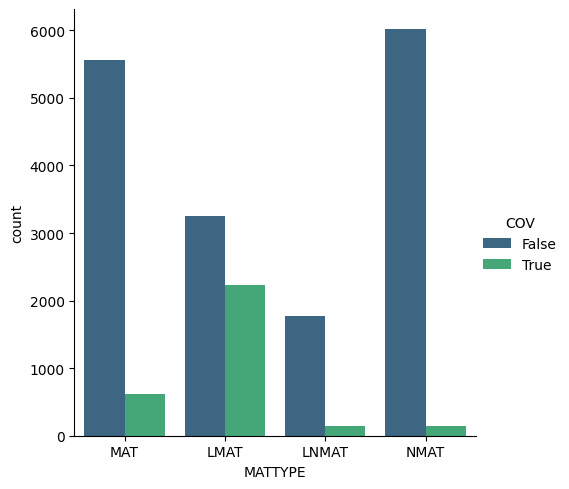

In [57]:
sns.catplot(data=df_result, x='MATTYPE', kind='count', hue = "COV", palette='viridis')

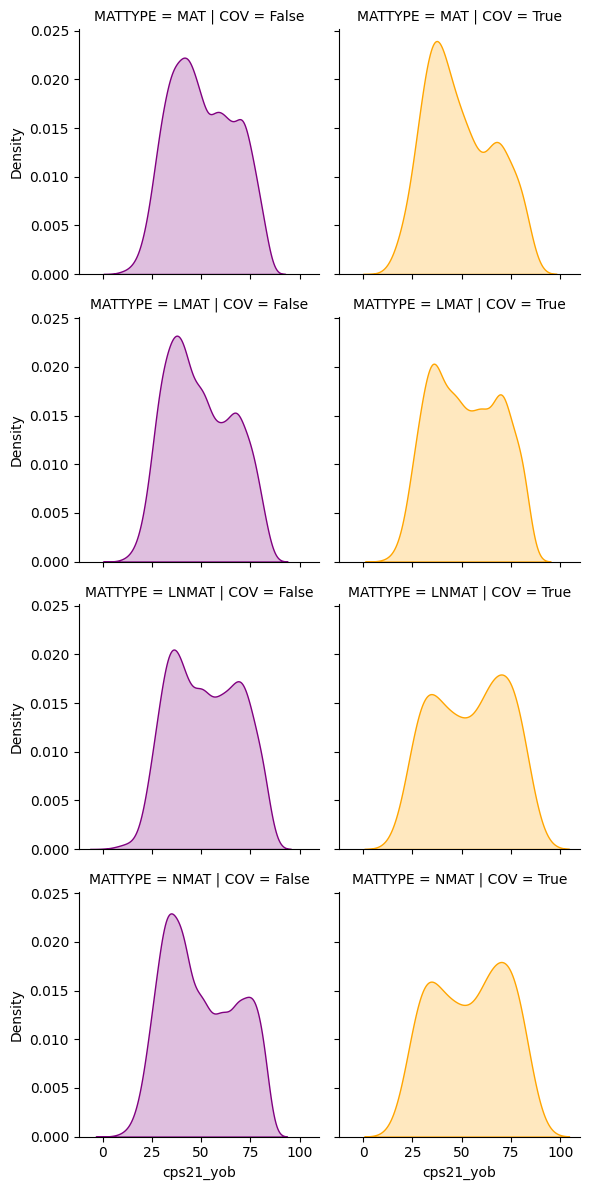

In [58]:
#TODO: Visualize distribution of material and non-material topics by age
g = sns.FacetGrid(df_result, row="MATTYPE", col = "COV", hue = "COV", palette=['purple','orange'])
g.map_dataframe(sns.kdeplot, x = "cps21_yob", fill = True)

<Axes: xlabel='cps21_yob', ylabel='Density'>

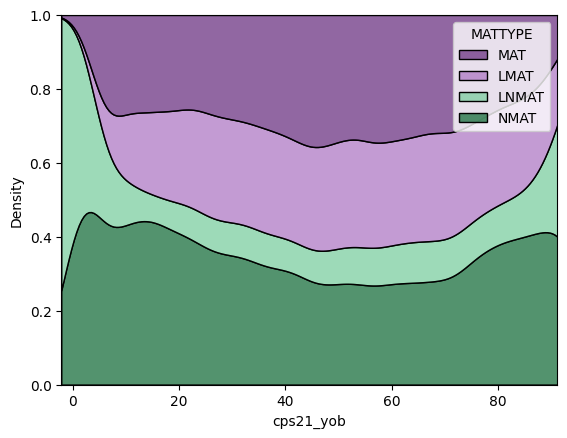

In [126]:
sns.kdeplot(data=df_result, x = "cps21_yob", hue = "MATTYPE", palette = ['#6c3483','#af7ac5', '#7dcea0', '#196f3d'],fill = True,multiple = "fill")

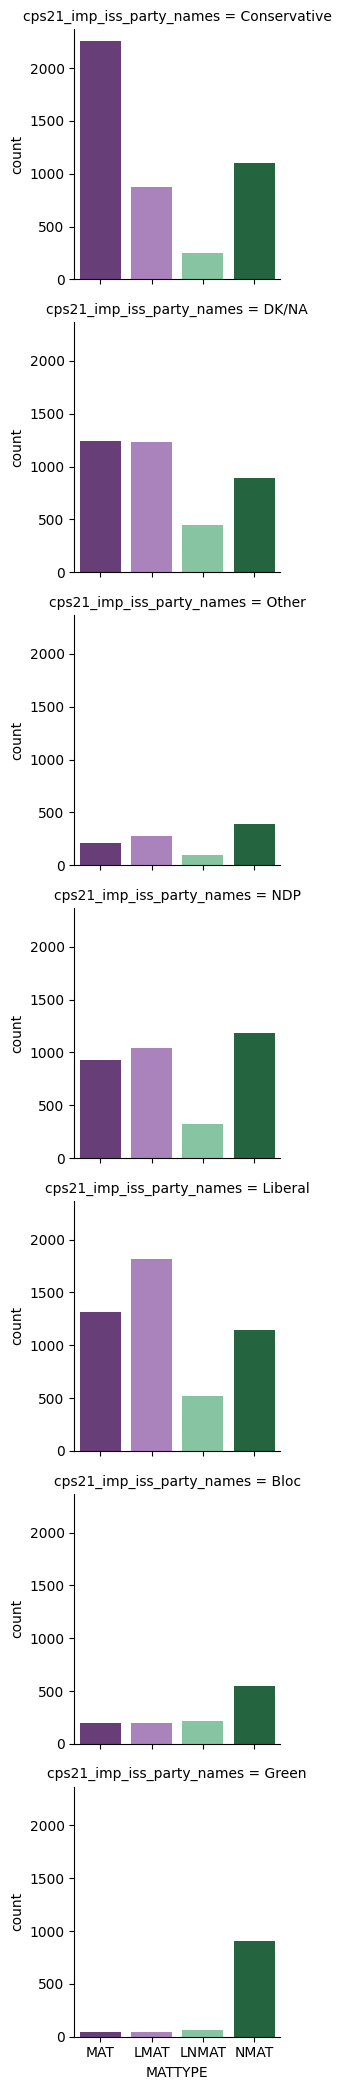

In [127]:
#TODO: Visualize the distribution of material and non-material topics by party.
g = sns.FacetGrid(df_result, row="cps21_imp_iss_party_names", hue = "MATTYPE", palette=['#6c3483','#af7ac5', '#7dcea0', '#196f3d'])
g.map_dataframe(sns.countplot,x='MATTYPE', stat = 'count')



In [132]:
df_result["BIN_MAT"] = df_result["MATTYPE"].apply(lambda x: "MAT" if x in ["MAT","LMAT"] else "NMAT" if x in ["LNMAT","NMAT"] else "OTHER")

<Axes: xlabel='cps21_imp_iss_party_names', ylabel='count'>

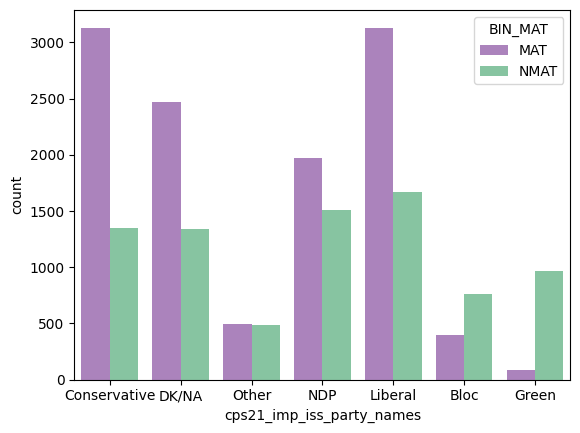

In [62]:
sns.countplot(data = df_result, x = "cps21_imp_iss_party_names",  hue = "BIN_MAT", palette = ['#af7ac5','#7dcea0'])

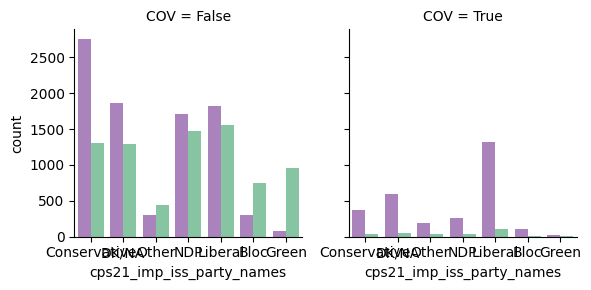

In [63]:
g = sns.FacetGrid(data = df_result, col = "COV")
g.map_dataframe(sns.countplot, x = "cps21_imp_iss_party_names",  hue = "BIN_MAT", palette = ['#af7ac5','#7dcea0'])


In [64]:
df_result["cps21_income_number"].describe()

count    1.976100e+04
mean     5.673788e+10
std      7.157787e+12
min     -9.900000e+01
25%      4.000000e+04
50%      7.000000e+04
75%      1.100000e+05
max      1.000000e+15
Name: cps21_income_number, dtype: float64

looking at the above, clearly someone reported some crazy income that is clearly false. ( no one makes 10^30)

I've considered multiple ways of eliminating outliers (eliminating outliers to normality is the wrong play, since its a severely skewed distribution.) I'm just going to eliminate anything over a billion dollars, because I can safely say that no-one makes over a billion dollars.

In [65]:
df_result = df_result[df_result["cps21_income_number"] < 1000000000]

<Axes: xlabel='cps21_income_number', ylabel='Count'>

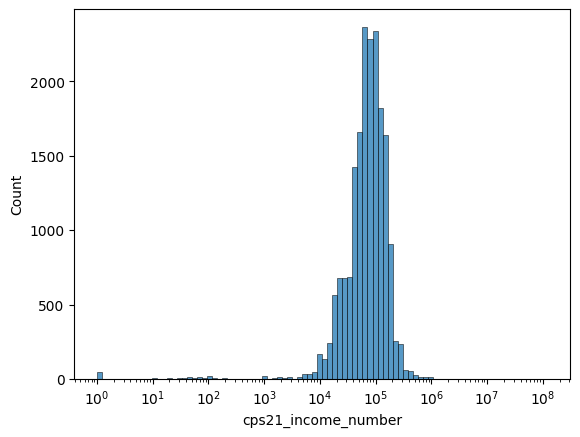

In [66]:
sns.histplot(data = df_result, x = "cps21_income_number", bins = 90, log_scale = True)

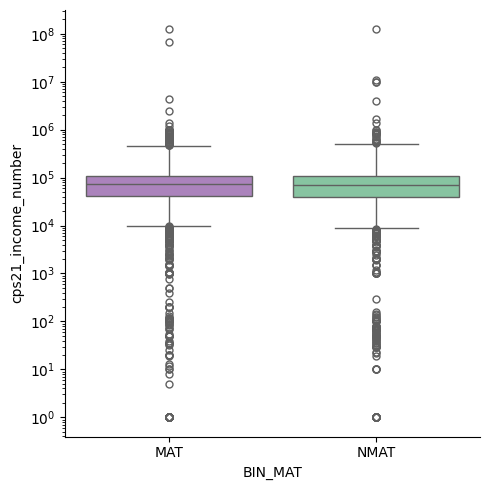

In [76]:
g = sns.catplot(data = df_result[(df_result.notna())],kind = "box", y = "cps21_income_number", x = "BIN_MAT", palette = ['#af7ac5','#7dcea0'], log_scale = True)


<Axes: xlabel='cps21_income_number', ylabel='cps21_yob'>

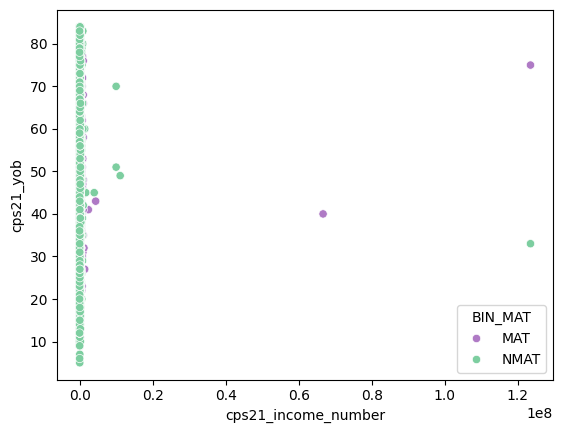

In [82]:
sns.scatterplot(data = df_result, x = "cps21_income_number", y = "cps21_yob", hue = "BIN_MAT", palette = ['#af7ac5','#7dcea0'],)

In [87]:
df_result["LogIncome"].head()

0    10.691945
1    12.206073
2    11.695247
3    11.407565
4    11.552146
Name: LogIncome, dtype: float64

In [147]:
from IPython.display import HTML

In [150]:
#TODO: Regress Issues against income, build controlling for age location and education.
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
df_result['MATIO'] = df_result['BIN_MAT'].apply(lambda x: 1 if x =="MAT" else 0)


df_reg = df_result.dropna()
df_reg = df_reg[df_reg["cps21_income_number"] > 0]
df_reg['LogIncome'] = np.log(df_reg['cps21_income_number'])

a = smf.ols("MATIO ~ LogIncome", data = df_reg).fit()
b = smf.ols("MATIO ~ LogIncome + cps21_yob", data = df_reg).fit()
c = smf.ols("MATIO ~ LogIncome + cps21_yob + C(cps21_education)", data = df_reg).fit()
stargazer = Stargazer([a,b,c])
stargazer.covariate_order(['LogIncome', 'cps21_yob'])
stargazer.add_line('Education Controls',['No','No','Yes'])

stargazer.title('Regression of Material Topics on Income, Age, and Education')
stargazer

In [151]:
#TODO: If you have time, Do the same pipeline on the previous canadian election. See if Covid Associated views affect materialism values by eroding perceived security.
#Without COVID concerns
c = smf.ols("MATIO ~ LogIncome", data = df_reg[~df_reg["COV"]]).fit()
d = smf.ols("MATIO ~ LogIncome + cps21_yob", data = df_reg[~df_reg["COV"]]).fit()
e = smf.ols("MATIO ~ LogIncome + cps21_yob + C(cps21_education)", data = df_reg[~df_reg["COV"]]).fit()
stargazer = Stargazer([c,d,e])
stargazer.covariate_order(['LogIncome', 'cps21_yob'])
stargazer.add_line('Education Controls',['No','No','Yes'])

stargazer


\begin{table}[!htbp] \centering
  \caption{Regression of Material Topics on Income, Age, and Education, without COVID concerns}
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable: MATIO}} \
\cr \cline{2-4}
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 LogIncome & 0.004$^{}$ & 0.004$^{}$ & 0.009$^{***}$ \\
& (0.003) & (0.003) & (0.004) \\
 cps21_yob & & -0.000$^{}$ & 0.000$^{}$ \\
& & (0.000) & (0.000) \\
 Education Controls & No & No & Yes \\
\hline \\[-1.8ex]
 Observations & 15694 & 15694 & 15694 \\
 $R^2$ & 0.000 & 0.000 & 0.008 \\
 Adjusted $R^2$ & 0.000 & -0.000 & 0.007 \\
 Residual Std. Error & 0.499 (df=15692) & 0.499 (df=15691) & 0.497 (df=15680) \\
 F Statistic & 1.349$^{}$ (df=1; 15692) & 0.675$^{}$ (df=2; 15691) & 9.479$^{***}$ (df=13; 15680) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{3}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


In [152]:
#No Middle cases
df_reg["MATIOEX"] = df_reg["MATTYPE"].apply(lambda x: 1 if x =="MAT" else 0 if x == "NMAT"  else None)
df_reg2 = df_reg.dropna()
c = smf.ols("MATIO ~ LogIncome", data = df_reg2).fit()
d = smf.ols("MATIO ~ LogIncome + cps21_yob", data = df_reg2).fit()
e = smf.ols("MATIO ~ LogIncome + cps21_yob + C(cps21_education)", data = df_reg2).fit()
stargazer = Stargazer([c,d,e])
stargazer.covariate_order(['LogIncome', 'cps21_yob'])
stargazer.add_line('Education Controls',['No','No','Yes'])

stargazer.title('Regression of Material Topics on Income, Age, and Education, without Leaning Cases')
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
  \caption{Regression of Material Topics on Income, Age, and Education, without Leaning Cases}
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable: MATIO}} \
\cr \cline{2-4}
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 LogIncome & 0.013$^{***}$ & 0.013$^{***}$ & 0.018$^{***}$ \\
& (0.004) & (0.004) & (0.004) \\
 cps21_yob & & 0.001$^{**}$ & 0.001$^{***}$ \\
& & (0.000) & (0.000) \\
 Education Controls & No & No & Yes \\
\hline \\[-1.8ex]
 Observations & 11706 & 11706 & 11706 \\
 $R^2$ & 0.001 & 0.001 & 0.010 \\
 Adjusted $R^2$ & 0.001 & 0.001 & 0.009 \\
 Residual Std. Error & 0.500 (df=11704) & 0.500 (df=11703) & 0.498 (df=11693) \\
 F Statistic & 11.403$^{***}$ (df=1; 11704) & 8.264$^{***}$ (df=2; 11703) & 9.371$^{***}$ (df=12; 11693) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{3}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}
